## Loading libraries

In [1]:
%pylab inline 
from datetime import datetime
from sklearn import decomposition
from sklearn.cluster import MiniBatchKMeans, KMeans, MeanShift, estimate_bandwidth
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timeit
from scipy import signal
from sklearn.decomposition import FastICA, PCA

pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
figsize(20, 8)

Populating the interactive namespace from numpy and matplotlib


## Load data from CSV file

17/12/2006
10/11/2008
         Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  17/12/2006  00:00:00                1.044                  0.152   242.73   
1  17/12/2006  00:01:00                1.520                  0.220   242.20   
2  17/12/2006  00:02:00                3.038                  0.194   240.14   
3  17/12/2006  00:03:00                2.974                  0.194   239.97   
4  17/12/2006  00:04:00                2.846                  0.198   240.39   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0               4.4               0               2               0  
1               7.4               0               1               0  
2              12.6               0               2               0  
3              12.4               0               1               0  
4              11.8               0               2               0  
              Date      Time  Global_active_power  Global_reactive_power  \
9

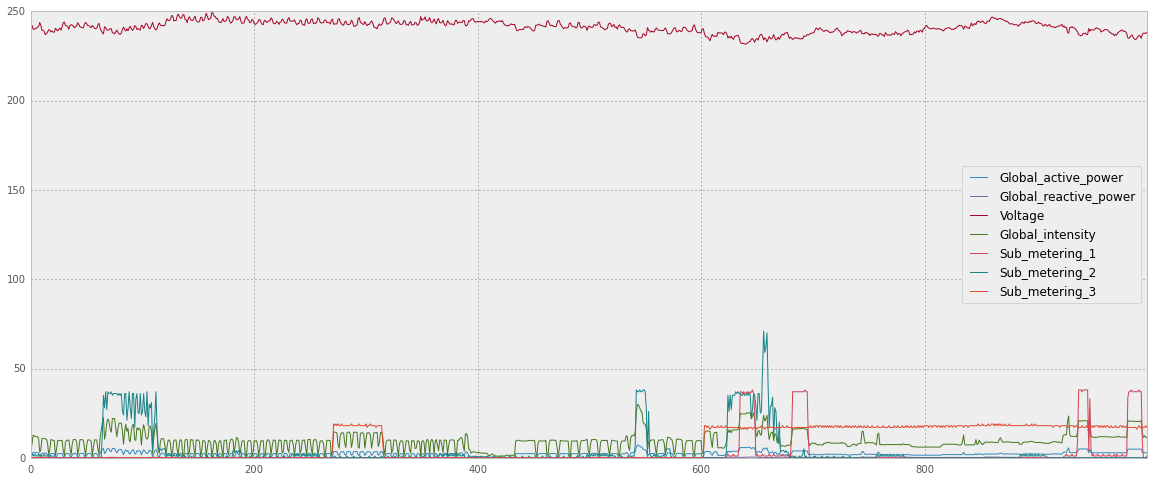

In [234]:
filename1='household_power_consumption_100k.csv'
filename2='GEG_1.csv'
#dtypes = [datetime, datetime, float, float, float, float, float, float, float]
data = pd.read_csv(filename1, encoding='latin1', sep =";" )#, parse_dates=['Date'], dayfirst=True, index_col='Date')
#data[["Global_active_power"]]=data[["Global_active_power"]].astype(np.float64)
#print data.dtypes
#keep start date and end date
#keep the start date and end date of data
start_date = data.iloc[1]["Date"]
end_date = data.iloc[-1]["Date"]
print start_date
print end_date
print data.head()
print data.tail()
#data.describe()
data.head(1000).plot()

In [235]:
#combining date and time and set it as index
data["Date Time"] = pd.to_datetime(data["Date"]+ " "+data["Time"])

if ('Global_active_power' in data.columns):
    data.rename(columns={'Global_active_power': 'Value'}, inplace=True)    
    data["Value"] *= 1000 #to convert W to kW
    #data = data.loc[:,["Value"]]#keep only the column "value"
data["Value"] /= 1000 #to convert W to kW
data.set_index('Date Time', inplace=True)
data = data.loc[:,["Value"]].dropna()#keep only the column "value"
#print data.tail(10)

               Value
count  999601.000000
mean        1.086788
std         1.124450
min         0.000000
25%         0.282000
50%         0.514000
75%         1.524000
max        10.670000


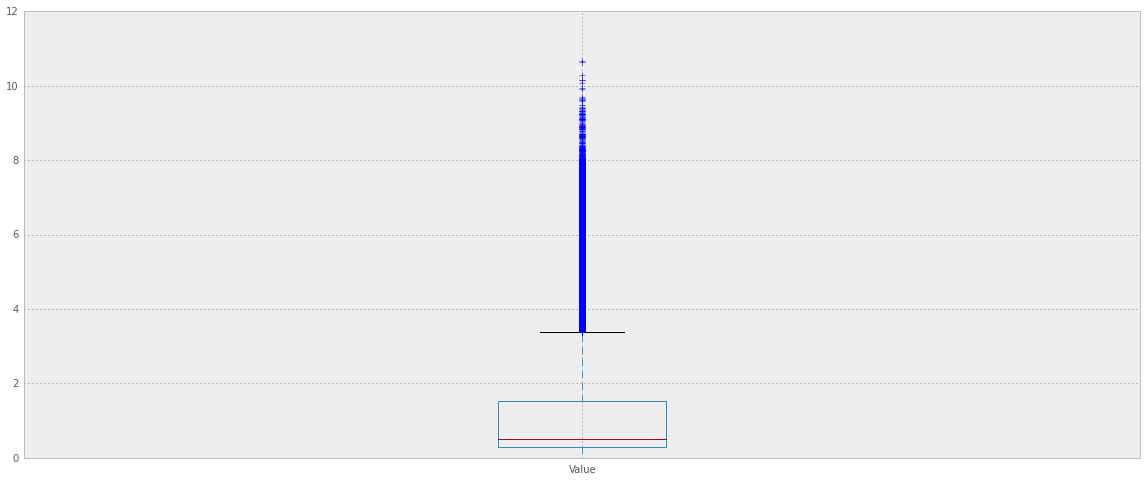

In [236]:
#show some stats
stat = data.describe()
print stat

data.plot(kind='box')
#save to tempo file
#data.to_csv("tmp.csv", sep=';')

                     Value
Date Time                 
2006-12-17 00:00:00  1.044
2006-12-17 00:01:00  1.520
2006-12-17 00:02:00  3.038
2006-12-17 00:03:00  2.974
2006-12-17 00:04:00  2.846
2006-12-17 00:05:00  2.848
2006-12-17 00:06:00  2.858
2006-12-17 00:07:00  2.472
2006-12-17 00:08:00  0.658
2006-12-17 00:09:00  0.838
                     Value
Date Time                 
2008-10-11 03:51:00  0.272
2008-10-11 03:52:00  0.272
2008-10-11 03:53:00  0.272
2008-10-11 03:54:00  0.272
2008-10-11 03:55:00  0.270
2008-10-11 03:56:00  0.270
2008-10-11 03:57:00  0.270
2008-10-11 03:58:00  0.270
2008-10-11 03:59:00  0.272
2008-10-11 04:00:00  0.272
Base 0.282
High  1.524


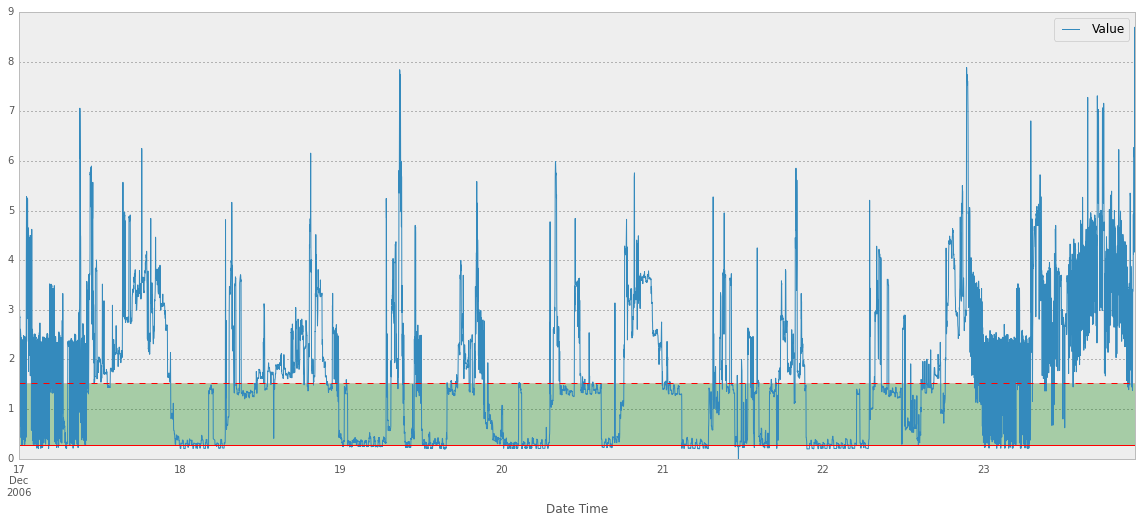

In [237]:
#visualize data
#data["15-02-2015"].plot()
#print data["15-02-2015"].head()
print data.head(10)
print data.tail(10)
ax = data[:10000].plot()

#detection of base consumation and plot on the same figure
base=float(data.quantile(0.25))
high=float(data.quantile(0.75))

print "Base", base
print "High ", high
ax.axhline(base, color='red', linestyle='-')
ax.axhline(high, color='red', linestyle='--')
ax.axhspan(base, high, facecolor='green', edgecolor='red',alpha=0.3)
#hlines(0.516000,0,250)
#plt.show()

In [ ]:
#test convert dataframe to time series (SKIPPED)
tmp = pd.read_csv("tmp.csv", index_col = ["Date Time"], parse_dates = ["Date Time"], sep =";")
series = pd.Series(tmp["Value"], index=tmp.index)
print series.head()
print series.tail()
start = series.head(1).index.values[0]
end = series.tail(1).index.values[0]
print start
print end

#tmp.plot()
series10=series.ix[start:end].resample('30T', how="mean", fill_method='pad')
#series10=series.groupby(pd.TimeGrouper(freq='30Min')).mean()
print series10.head()
print series10.tail()
#save to file
series10.to_csv("tmp_grp.csv", sep=';')

## Preprocessing data, resampling data

17/12/2006
10/11/2008
                       mean    max       std       var
Date Time                                             
2006-12-17 00:00:00  2.1096  3.038  0.977259  0.955034
2006-12-17 00:10:00  2.0466  2.608  0.812176  0.659630
2006-12-17 00:20:00  1.7972  2.368  0.878924  0.772508
2006-12-17 00:30:00  1.7178  2.480  0.876271  0.767851
2006-12-17 00:40:00  1.6816  2.468  0.939299  0.882282
2006-12-17 00:50:00  1.9420  2.456  0.768280  0.590254
2006-12-17 01:00:00  3.3216  5.282  1.701460  2.894968
2006-12-17 01:10:00  4.2896  5.254  0.865427  0.748963
2006-12-17 01:20:00  3.4162  4.652  1.057148  1.117562
2006-12-17 01:30:00  3.4082  4.460  0.977803  0.956098
                       mean    max       std       var
Date Time                                             
2008-10-11 02:20:00  0.2780  0.280  0.001333  0.000002
2008-10-11 02:30:00  0.3716  0.452  0.053548  0.002867
2008-10-11 02:40:00  0.4500  0.458  0.005578  0.000031
2008-10-11 02:50:00  0.3368  0.382  0.04247

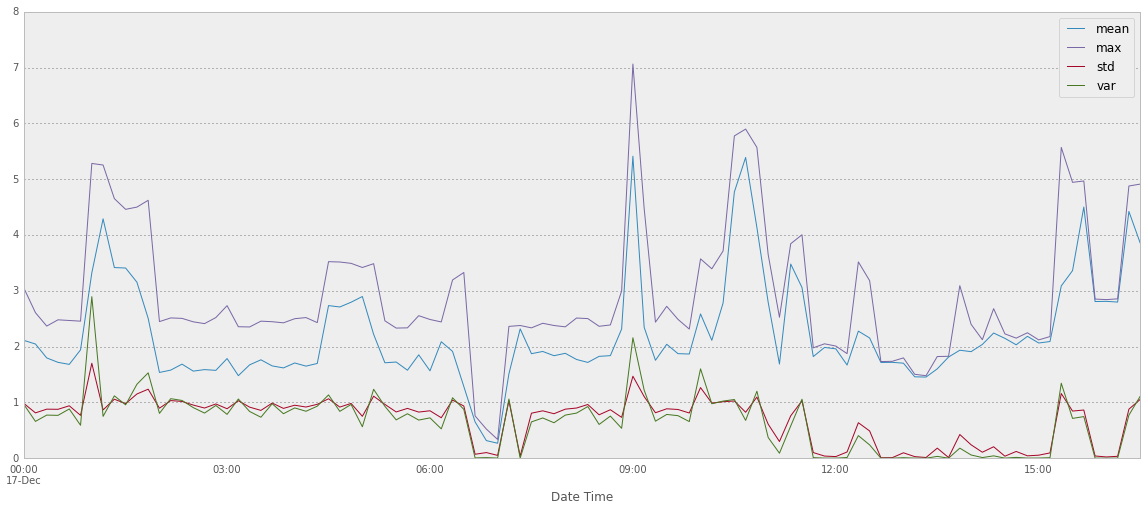

In [314]:
print start_date
print end_date
#resampling data with a period of time (T (min),H (hours))
res=['mean', 'max', 'std', 'var']
#data_10=data.resample('30T', how=res, label ="left")
#print data_10.head(10)
data_10=data.ix[start_date:end_date].resample('10T', how=res).dropna()
#data_10 = data_10.loc[:,["Value"]]#keep only the column "value"  
data_10.columns = data_10.columns.droplevel()#create a flat data structure
#data_10["norm"] = data_10["mean"]/data_10[["max"]].max(axis=1)#nomalized mean
print data_10.head(10)
print data_10.tail(10)
#print data_10["2-12-2015"]
data_10.head(100).plot()#(subplots=True)
#save to file
data_10.to_csv("tmp_grp.csv", sep=';')

                         mean    max       std       var     delta
Date Time                                                         
2006-12-17 00:00:00  1.984467  3.038  0.871590  0.759670  0.000000
2006-12-17 00:30:00  1.780467  2.480  0.842030  0.709015 -0.204000
2006-12-17 01:00:00  3.675800  5.282  1.293877  1.674119  1.895333
2006-12-17 01:30:00  3.023000  4.622  1.153982  1.331674 -0.652800
2006-12-17 02:00:00  1.600333  2.514  0.951679  0.905693 -1.422667
2006-12-17 02:30:00  1.574200  2.520  0.908675  0.825689 -0.026133
2006-12-17 03:00:00  1.645933  2.734  0.921668  0.849472  0.071733
2006-12-17 03:30:00  1.678467  2.456  0.884349  0.782073  0.032533
2006-12-17 04:00:00  1.684800  2.520  0.911475  0.830786  0.006333
2006-12-17 04:30:00  2.746733  3.522  0.955396  0.912782  1.061933


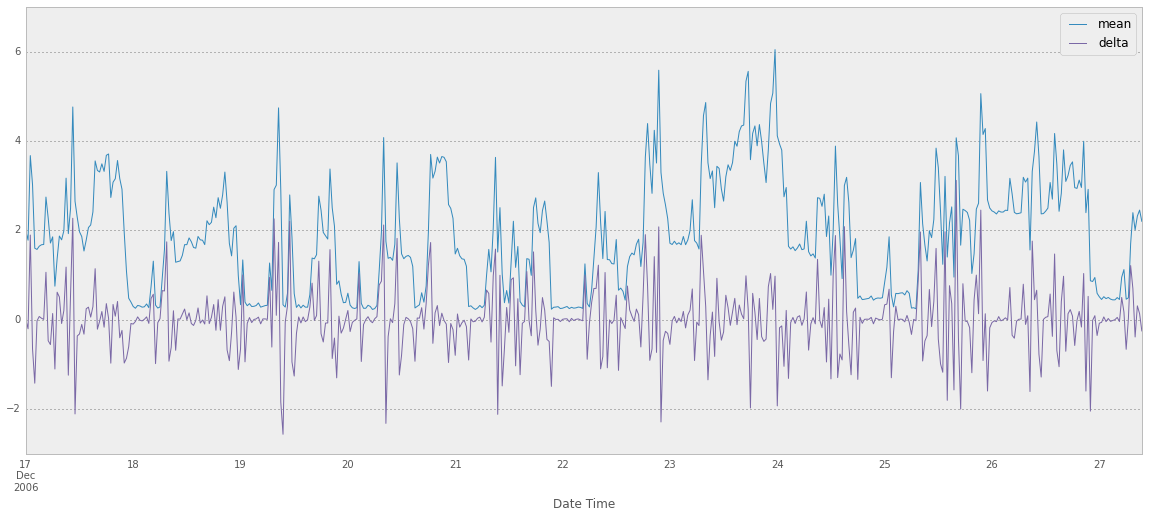

In [240]:
#Feature extraction from value
#data_10["delta"]=(data_10["Value"]["mean"]-data_10["Value"]["mean"].shift()).fillna(0)
#compute the different of value in time series
data_10["delta"]=(data_10["mean"]-data_10["mean"].shift()).fillna(0)
print data_10.head(10)
data_10[["mean","delta"]].head(500).plot()

Base 0.296266666667
High 1.57836666667


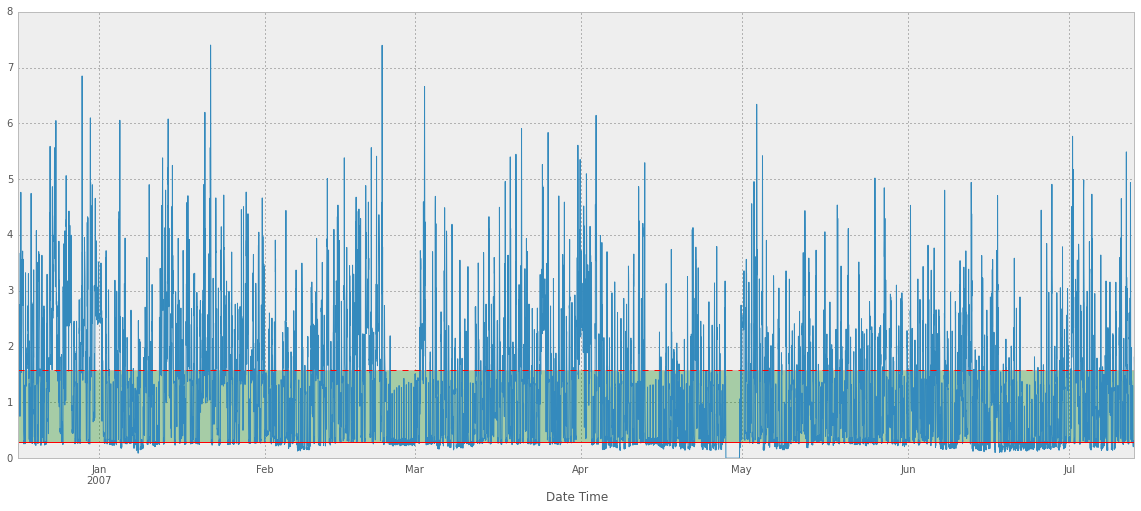

In [241]:
#plot data to compare 
#data["Value"].head(1000).plot()
ax = data_10["mean"][0:10000].plot()#(subplots=True)
#print data["Value"]['2007-03':'2007-04']
#detection of base consumation and plot on the same figure
#print data_10["mean"].quantile(0.25)
base=float(data_10["mean"].quantile(0.25))
high=float(data_10["mean"].quantile(0.75))

print "Base", base
print "High", high
ax.axhline(base, color='red', linestyle='-')
ax.axhline(high, color='red', linestyle='--')
ax.axhspan(base, high, facecolor='green', edgecolor='red',alpha=0.3)

## Clustering data by day, 1/2 day etc..

In [458]:
#group data frame by day (haft day, quart day)
period = '6H'#quart day
#period = '12H'#half day
data_group = data_10["mean"].groupby(pd.TimeGrouper(period))
#print data_group.groups.keys()
row = len(data_group.groups.keys())
for group in data_group:
    #print group #get the second element of tuple
    col = group[1].shape[0] #get the size of dataframe
    break;
print row, col

2657 36


In [459]:
#convert data group to a feature matrix
features = np.empty(shape=[0,col])
timestamp = []
sum_period = []
mean_period = []
#print features
for time, group in data_group:
    timestamp.append(time)
    #print group.values
    arr = array(group.fillna(0))
    #print arr
    if (arr.size != col):
        arr = np.full(col, 0) #fill zeros to empty array
        #print arr
    features = np.append(features, [arr], axis=0)
    mean_period.append(np.mean(arr))
    sum_period.append(np.sum(arr))
print features.shape
print features
#print powersum

(2657, 36)
[[ 2.1096  2.0466  1.7972 ...,  1.7234  1.5768  1.8524]
 [ 1.5662  2.0872  1.9144 ...,  3.0592  1.821   1.9852]
 [ 1.96    1.6698  2.2772 ...,  3.1478  3.3222  3.4974]
 ..., 
 [ 1.3348  1.3092  1.3392 ...,  0.2606  0.309   0.4364]
 [ 0.417   0.5312  0.7196 ...,  1.0466  1.062   0.6654]
 [ 0.      0.      0.     ...,  0.      0.      0.    ]]


In [526]:
#clustering data and aggreate the labels to data frame
print features.shape
nb_cls = 6
cls = KMeansClustering(features, nb_cls)
#cls = MeanshiftClustering(features)
print cls.labels_

(2657, 36)
Clusters: (6, 36)
[3 3 3 ..., 4 5 1]


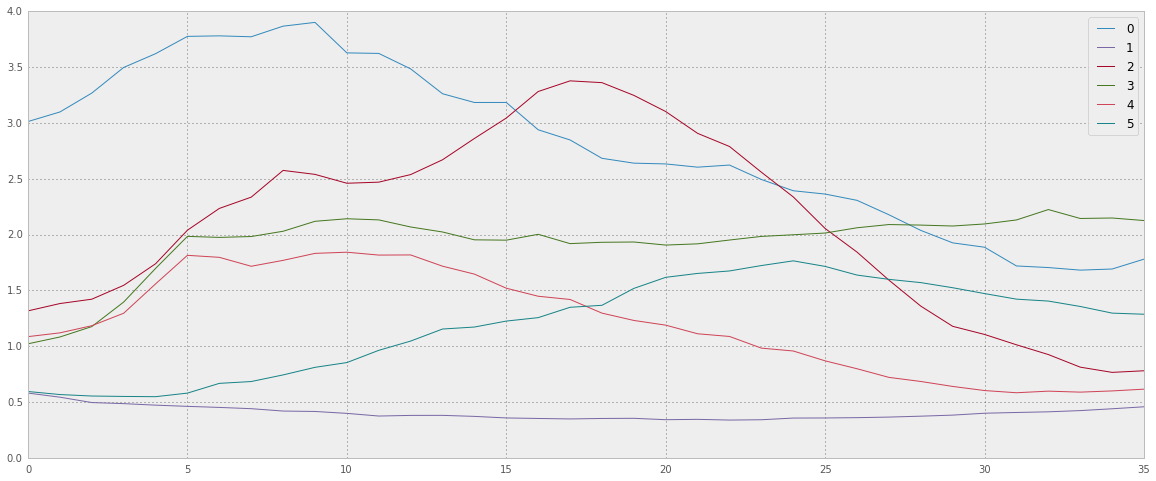

In [527]:
#plot cluster centers
centers = cls.cluster_centers_
i = 0
for cen in centers:
    plt.plot(range(col),cen, label = i)
    plt.legend()
    i+=1

In [517]:
def plot_cluster(c, lim = 10):
    i = 0
    j = 0
    plt.plot(range(col),cls.cluster_centers_[c],'ro-')
    for lab in cls.labels_:
        #print lab
        if (lab == c):            
            plt.plot(range(col),features[i], 'b--', label = timestamp[i])
            plt.legend()
            j+=1
        if (j > lim):
            break
        i+=1

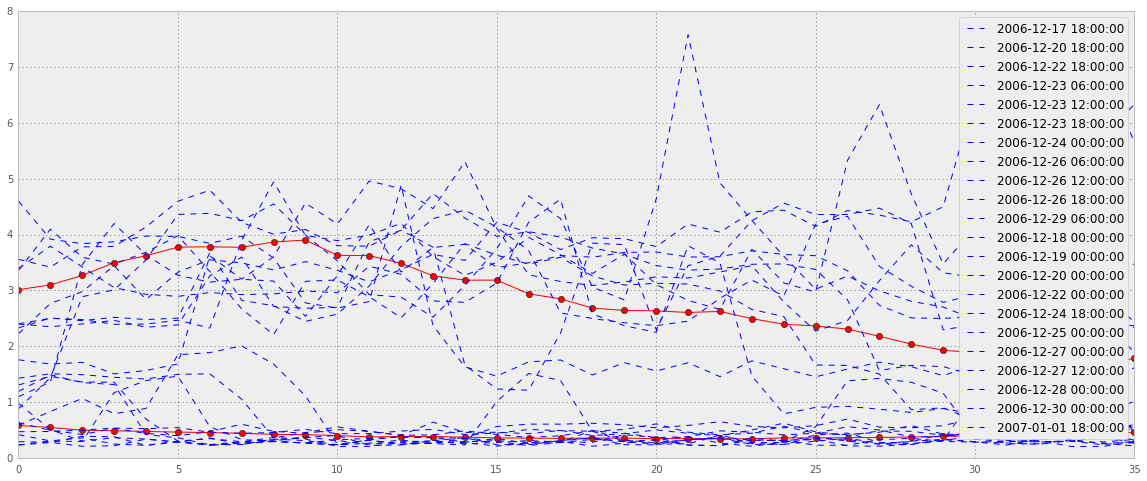

In [528]:
plot_cluster(0, 10)
plot_cluster(1, 10)

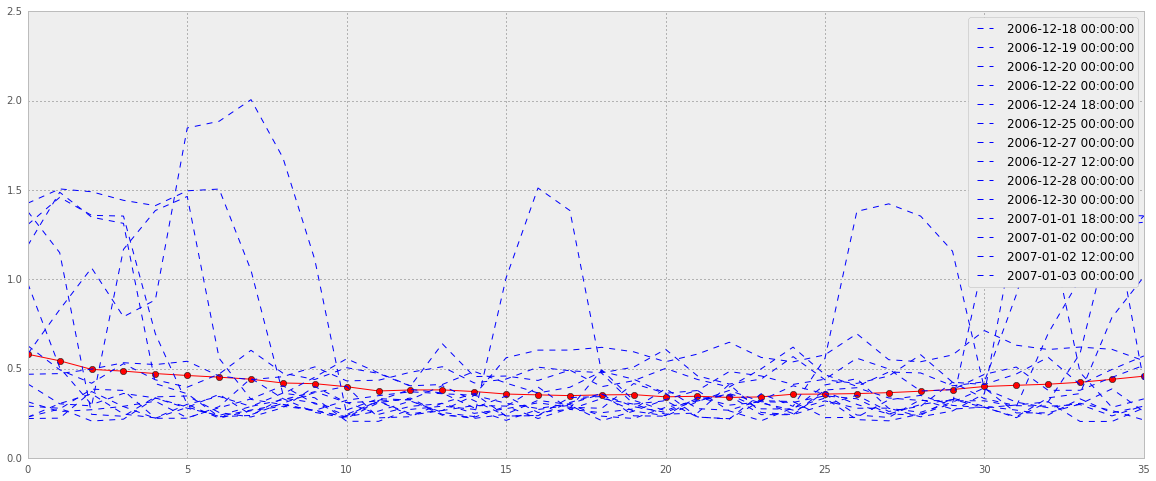

In [529]:
#try interactive plot
from IPython.html import widgets
from IPython.html.widgets import interact
interact(plot_cluster, c=(0, nb_cls-1), lim=(0,100))

                     label      mean        sum
2006-12-17 00:00:00      3  2.115639  17.755269
2006-12-17 06:00:00      3  2.243811  14.926124
2006-12-17 12:00:00      3  2.564578  20.512064
2006-12-17 18:00:00      0  2.493917  21.923471
2006-12-18 00:00:00      1  0.417317  10.563493
                     label      mean        sum
2008-10-10 00:00:00      1  0.416706  11.105567
2008-10-10 06:00:00      3  1.719356  16.503173
2008-10-10 12:00:00      4  0.982961  22.328748
2008-10-10 18:00:00      5  1.098583  18.113493
2008-10-11 00:00:00      1  0.000000        NaN


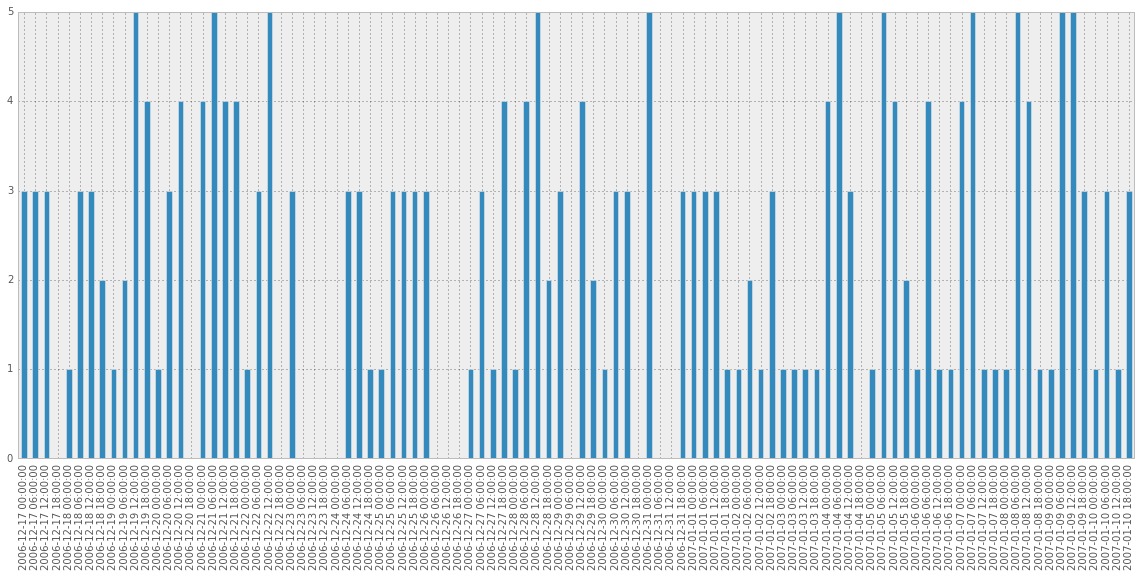

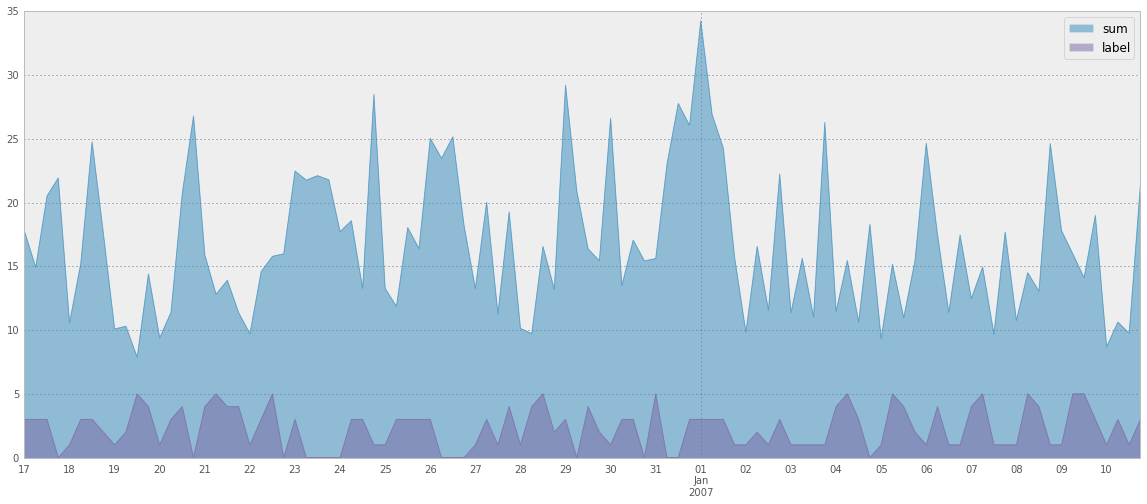

In [530]:
#aggregate the label to data frame
labels = pd.DataFrame({"label":cls.labels_,"sum":sum_period,"mean":mean_period}, index = timestamp)
print labels.head()
print labels.tail()
labels["label"][0:100].plot(kind='bar', stacked=False)
labels[["sum", "label"]][0:100].plot(kind='area', stacked=False)

             label         mean          sum
count  2657.000000  2657.000000  2611.000000
mean      2.320662     1.071042    14.531903
std       1.600639     0.767826     4.855996
min       0.000000     0.000000     1.662621
25%       1.000000     0.409600    10.926276
50%       2.000000     0.905617    13.726739
75%       4.000000     1.584267    17.200607
max       5.000000     4.236961    34.252770


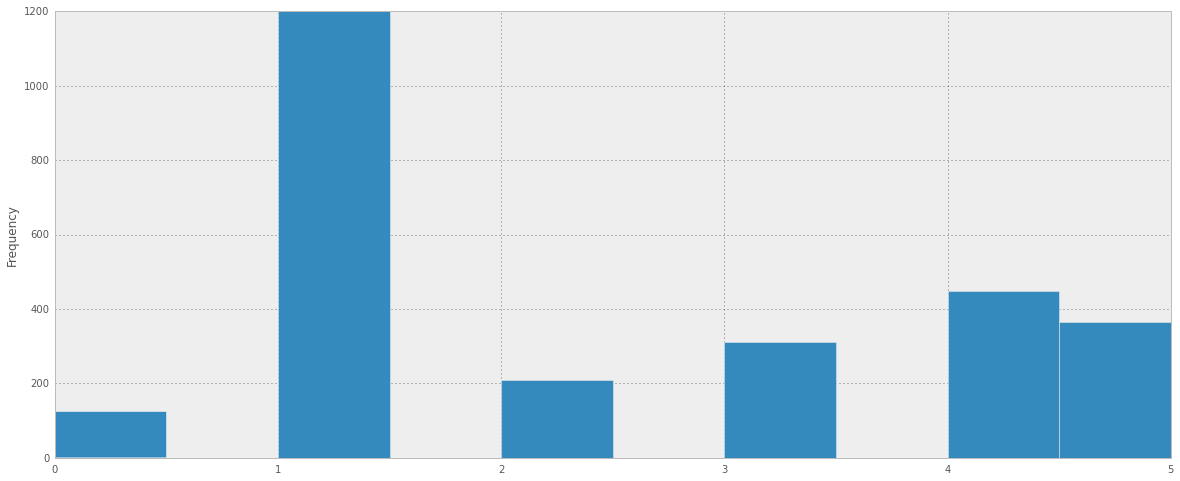

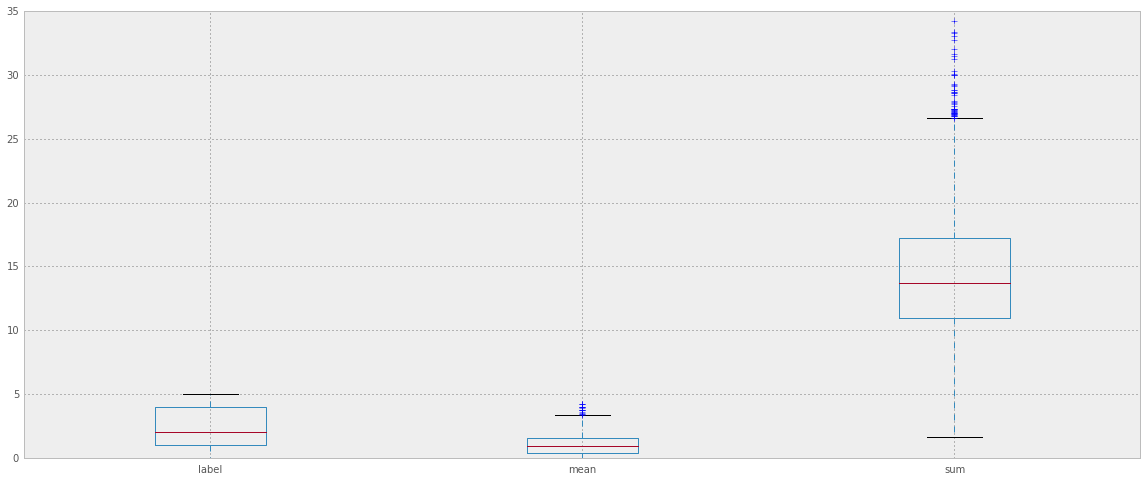

In [531]:
#show some stat
labels["label"].plot(kind="hist")
print labels.describe()
labels.plot(kind="box")

## Try clusterring data to some clusters

In [297]:
%timeit #aaa
#convert dataframe to feature array
#cols = ["Value", "delta"]
cols = ["delta", "mean"]
df = data_10[cols].fillna(0)
#df = data_10.fillna(0)
features = array(df)
#feature_norm = array(df/df.max(axis=0))#normalize feature vector
print features.shape
print features

#test cluster
#cls=KMeansClustering(features, 10)
cls = MeanshiftClustering(features)

100000000 loops, best of 3: 13.4 ns per loop
(31448, 2)
[[ 0.          1.98446667]
 [-0.204       1.78046667]
 [ 1.89533333  3.6758    ]
 ..., 
 [ 0.09473333  0.38613333]
 [-0.02306667  0.36306667]
 [-0.03813333  0.32493333]]
(9, 2)
[[-0.02670272  0.34312876]
 [-0.03554817  1.39435655]
 [ 3.39051282  5.6730359 ]
 [ 0.55091429  6.35277143]
 [ 4.10986667  6.705     ]
 [ 3.33877778  7.28177778]
 [ 2.60048889  7.44846667]
 [-2.6613      4.80946667]
 [-0.9568      6.44706667]]


In [354]:
#clustering the data using kmeans algorithm
def KMeansClustering(features, nb =10, shape = 1):
    #normal version of kmeans >> pretty slow
    #km=KMeans(init='random', n_clusters=nb, n_init=features.shape[0]/shape)

    #for paralel computing, try mini bactch kmeans
    km=MiniBatchKMeans(init='k-means++', n_clusters = nb, batch_size=features.shape[0]/shape, n_init=features.shape[0]/shape, max_no_improvement=10)
    km.fit(features)
    print "Clusters:", km.cluster_centers_.shape
    #print km.cluster_centers_
    
    return km

In [355]:
def MeanshiftClustering(features, quant = 0.2, shape = 1):
    
    #clustering the data using mean shift algorithm
    bandwidth = estimate_bandwidth(features, quantile=quant, n_samples=features.shape[0]/shape)
    cls=MeanShift(bandwidth=bandwidth, bin_seeding=True)
    #cls=MeanShift(bin_seeding=True)
    cls.fit(features)
    print "Clusters:", cls.cluster_centers_.shape
    #print cls.cluster_centers_
    
    return cls

In [296]:
#label = pd.DataFrame({"label":km.labels_}, index = data_10.index)
%timeit #measure executing time 
cls = MeanshiftClustering(features)
label = pd.DataFrame({"label":cls.labels_}, index = data_10.index)
print label.head()
print label.tail()
label.plot(kind="hist")
#concatenate label column to the dataframe
if 'label' in data_10.columns:
    data_10.drop(['label'], axis=1, inplace=True)
data_10 = pd.concat([data_10, label], axis=1)
print data_10.head()
print data_10.tail()
#data_10['labels'].head(1000).plot(kind='area', stacked=False)
data_10[["mean",'label']].head(1000).plot(kind='area', stacked=False)

The slowest run took 89.31 times longer than the fastest. This could mean that an intermediate result is being cached 
100000000 loops, best of 3: 13.3 ns per loop
(1, 48)
[[ 0.57964863  0.48720324  0.43403608  0.38862889  0.36011572  0.34060423
   0.34508739  0.31669387  0.32443087  0.34389161  0.34574165  0.35841677
   0.43837393  0.98617449  1.27406018  1.38045046  1.30749232  1.21354743
   1.11545539  1.11070416  1.01699718  0.94161142  0.94916448  0.89270669
   0.82917266  0.8200902   0.77451219  0.73952361  0.79501945  0.72297872
   0.685358    0.67963566  0.65940987  0.63700197  0.65324299  0.70154545
   0.81826216  0.97567851  1.30031163  1.39374954  1.45686892  1.58899112
   1.64461395  1.59396927  1.41888485  1.1125525   0.8793098   0.71889993]]


ValueError: Shape of passed values is (1, 665), indices imply (1, 31448)

## Try some component analysis : PCA, ICA, Sparse coding

In [ ]:
#signal decomposing
signal = array(data_10["Value"].fillna(0))
#signal = data_10["Value"].values
print signal
signal_norm = signal/signal.max(axis=0)#normalize signal
print signal_norm
plt.plot(signal_norm[:1000])

In [ ]:
#convert dataframe to array or sparse matrix
import scipy as sp
arr = data.as_matrix()#.values
print type(arr)
print arr
mat = sp.sparse.csr_matrix(data_10.values.T)
print type(mat)
print mat

In [ ]:
#print data
#data_grp=data.groupby(data['Date Time'].map(lambda x: x.year))
data_grp=data.groupby(lambda x: x.day)
for week, group in data_grp:
    print week
    print group
#print data_grp

In [ ]:
from sklearn_pandas import DataFrameMapper, cross_val_score
sub_data=data[["Value"]]
sub_data["byday"]=data.index.year
sub_data_group=sub_data.groupby("byday").aggregate(sum)
print sub_data.head(100)
sub_data_group.plot()

In [ ]:
#compute PCA
pca = decomposition.PCA(n_components=5)
H = pca.fit_transform(signal_norm)
print pca.components_
#plt.plot(H)

In [ ]:
# Compute ICA
ica = decomposition.FastICA()
S_ = ica.fit_transform(signal_norm)
A_ = ica.mixing_.T
np.allclose(X,  np.dot(S_, A_) + ica.mean_)

### Unit tests

In [ ]:
#convert data frame to time series
idx = pd.to_datetime(data["Date"]+" "+data["Time"])
ts = pd.Series(data=data["Global_active_power"]*1000, index = idx)
#print ts.dtypes
print ts.head(10)
ts.head(1000).plot()

#resampling data to x min
ts=ts.resample('10T', how='sum')
#print ts.dtypes
print ts.head(10)
ts.head(1000).plot()

In [ ]:
#export time data frame to a csv file
fname = "test.csv"
cols = ["Value"]
#data_10.to_csv(fname, sep=';', columns = cols);
data_10.to_csv(fname, sep=';')

In [ ]:
#data["Global_active_power"]=data["Global_active_power"].astype(np.float64)
#print data[["Time", "Global_active_power"]].head(10)
#print "\n"
#print data[["Time", "Global_active_power"]].tail(10)
sub=data[0:5]
print sub
sub.plot(figsize=(15, 10), kind='bar')
#data

In [ ]:
#data["Global_active_power"]

#sub_data=data[["Sub_metering_3"]]
sub_data=data[["Sub_metering_3"]].astype(float)
sub_data["byday"]=sub_data.index.day
sub_data_group=sub_data.groupby("byday").aggregate(mean)
#print sub_data_group.head(100)
sub_data_group.plot(figsize=(15, 10))

Transform the data from 1 minute to 10 minutes 

In [ ]:
#print filter(lambda x: x/10!=0, x)
data_10=data.groupby([lambda x: x.month]).mean().plot()
data_10

In [ ]:
#data_10min = data.groupby("Time").head(10)
#print data.head(20)
#dta_10min = np.array_split(data, 10)
def splitDataFrameIntoSmaller(df, chunkSize = 10000): 
    listOfDf = list()
    numberChunks = len(df) // chunkSize + 1
    for i in range(numberChunks):
        listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
    return listOfDf
data_10mins = splitDataFrameIntoSmaller(data, 10)
print data_10mins

In [ ]:
# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations
print X
# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

In [ ]:
# Plot results
print S_

plt.figure()

models = [X, S, S_]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.show()